# **Analisis Espacial**

Empezamos generando unos datos artificiales.

In [1]:
import numpy as np
s = np.array([[5,20],[20,2],[25,32],[8,39],[10,17],[35,20],[38,10]]) # Coordenadas
z = np.array([[100,70,60,90,50,80,40]]).T # magnitudes de cada coordenada
s_star = np.array([20,20]) # Coordenada a evaluar o estimar su magnitud

In [ ]:
np.mean(z)

70.0

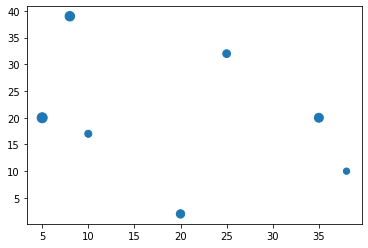

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(s[:,0],s[:,1],z)

## Usando interpolacion de scipy

La documentacion de la funcion RBF esta disponible [aqui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html).

In [ ]:
from scipy.interpolate import Rbf

In [ ]:
rbfi = Rbf(s[:,0],s[:,1], z, function = 'gaussian')
z_est = rbfi(s_star[0], s_star[1])
print(z_est)

32.156746499284544


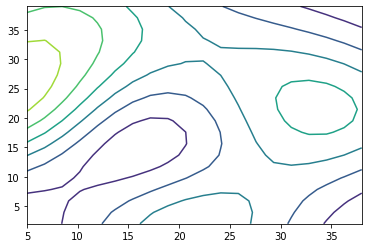

In [ ]:
s0 = np.linspace(np.min(s[:,0]), np.max(s[:,0]), 20)
s1 = np.linspace(np.min(s[:,1]), np.max(s[:,1]), 20)
ss0, ss1 = np.meshgrid(s0, s1)

z_grid = rbfi(ss0, ss1)

plt.contour(ss0, ss1, z_grid)

In [ ]:
rbfi = Rbf(s[:,0],s[:,1], z, function = 'cubic')
z_est = rbfi(s_star[0], s_star[1])
print(z_est)

52.21147090365459


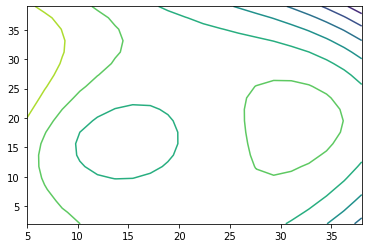

In [ ]:
s0 = np.linspace(np.min(s[:,0]), np.max(s[:,0]), 20)
s1 = np.linspace(np.min(s[:,1]), np.max(s[:,1]), 20)
ss0, ss1 = np.meshgrid(s0, s1)

z_grid = rbfi(ss0, ss1)

plt.contour(ss0, ss1, z_grid)

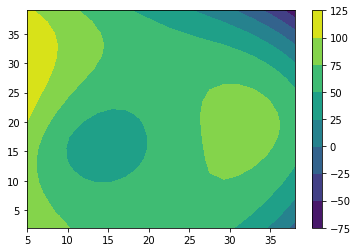

In [ ]:
cp = plt.contourf(ss0, ss1, z_grid)
plt.colorbar(cp)

(20, 20)

## Usando procesos Gaussianos 

In [ ]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

In [ ]:
reg = GPR(kernel = RBF()) # Se emplea el kernel RBF o exponencial cuadratico
reg.fit(X = s, y = z) #Se realiza la estimacion de los hiperparametros
ss_gp = np.vstack((ss0.flatten(), ss1.flatten())).T # Se agrupan los datos para la prediccion
predicted = reg.predict(ss_gp) #Se realiza la prediccion

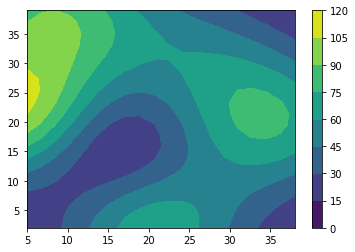

In [ ]:
cp = plt.contourf(ss0, ss1, predicted.reshape((20,20)))
plt.colorbar(cp)

In [ ]:
7

# **Análisis Espacio-Temporal**

Empezamos generando una base de datos espacio-temporal

In [38]:
t = np.linspace(0,1,50)
z1 = np.sin(2*np.pi*t)
z2 = np.cos(2*np.pi*t)
z3 = z1 + z2
s = np.array([[5,20],[20,2],[25,32]])
u = np.hstack((np.repeat(s, [50,50,50], axis = 0), np.hstack((z1,z2,z3))[:, np.newaxis]))

In [39]:
#np.repeat(s, [50,50,50], axis = 0)
#np.hstack((z1,z2,z3))[:, np.newaxis]

In [41]:
!pip install GPyTorch

     |████████████████████████████████| 491kB 20.8MB/s 


Se dispone de diferentes metodos para construir los [kernels](https://docs.gpytorch.ai/en/v1.1.1/kernels.html)

In [44]:
import gpytorch
from gpytorch.kernels import ProductKernel, RBFKernel

covar_module = RBFKernel(active_dims=torch.tensor([2])) * RBFKernel(active_dims=torch.tensor([1]))
x1 = torch.randn(50, 2)
kernel_matrix = covar_module(x1) # The RBF Kernel already decomposes multiplicatively, so this is foolish!

In [46]:
class GPRegressionModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
      super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

      self.mean_module = gpytorch.means.ConstantMean()
      self.covar_module = ScaleKernel(RBFKernel() + WhiteNoiseKernel())
      


  def forward(self, x):
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x)
      return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)